In [72]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import time

# modules specific to this project
import network as nw
import physics
import timemarching as tm
import plotter
import logger


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Define the broadcasting channels of the network
This is done by creating a list of the channel names. The names are arbitrary and can be set by the user, such as 'postive', 'negative' or explicit wavelenghts like '870 nm', '700 nm'. Here I chose the colors 'red' and 'blue'.

In [73]:
channel_list = ['blue','red']
# Automatically generate the object that handles them
channels = {channel_list[v] : v for v in range(len(channel_list))}

### 2. Define the layers
Define the layers of nodes in terms of how they are connected to the channels. Layers and weights are organized in dictionaries. The input and output layers do not need to be changed, but for the hidden layer we need to specify the number of nodes N and assign the correct channels to the input/output of the node.

In [74]:
# Create layers ordered from 0 to P organized in a dictionary
layers = {} 
Nring=5
# An input layer automatically creates on node for each channel that we define
layers[0] = nw.InputLayer(input_channels=channels)
# Forward signal layer
layers[1] = nw.HiddenLayer(N=1, output_channel='blue',excitation_channel='blue',inhibition_channel='red')
# Inhibiting memory layer
layers[2] = nw.HiddenLayer(N=1, output_channel='red' ,excitation_channel='blue',inhibition_channel='red')
layers[3] = nw.OutputLayer(output_channels=channels) # similar to input layer

### 3. Define existing connections between layers
The weights are set in two steps. 
First the connetions between layers are defined. This should be done using the keys defined for each layer above, i.e. 0, 1, 2 ... for input, hidden and output layers, respectively. The `connect_layers` function returns a weight matrix object that we store under a chosen key, for example `'inp->hid'`.
Second, the specific connections on the node-to-node level are specified using the node index in each layer

In [75]:
# Define the overall connectivity
weights = {}
# The syntax is connect_layers(from_layer, to_layer, layers, channels)
weights['inp->hd0'] = nw.connect_layers(0, 1, layers, channels)
weights['hd0->hd1'] = nw.connect_layers(1, 2, layers, channels)
weights['hd0->out'] = nw.connect_layers(1, 3, layers, channels)
# Backwards connection from the memory
weights['hd1->hd0'] = nw.connect_layers(2, 1, layers, channels)

# Define the specific node-to-node connections in the weight matrices
low_weight =  1.0 # 0.02
# The syntax is connect_nodes(from_node, to_node, channel=label, weight=value in weight matrix)
self_inhib = 1.0
# Draw a ring network with Nring nodes (Nring defined above)

# Input to first ring layer node
weights['inp->hd0'].connect_nodes(channels['blue'] ,0, channel='blue', weight=1.0) # channels['blue']=1
#weights['inp->hd0'].connect_nodes(channels['red'] ,0, channel='red', weight=1.0) # channels['blue']=1
# Hidden layer connections
weights['hd0->hd1'].connect_nodes(0 ,0 , channel='blue', weight=self_inhib) 
# Add damping connection
#weights['hd1->hd0'].connect_nodes(0 ,0 , channel='red', weight=self_inhib)    
# Connect to output
weights['hd0->out'].connect_nodes(0, channels['blue'], channel='blue', weight=0.9)


0

### 4. Visualize the network 
The `plotter` module supplies functions to visualize the network structure. The nodes are named by the layer type (Input, Hidden or Output) and the index. To supress the printing of weight values on each connection, please supply `show_edge_labels=False`.

#### Available layouts:
**multipartite**: Standard neural network appearance. Hard to see recurrent couplings within layers.  
**circular**: Nodes drawn as a circle  
**shell**: Layers drawn as concetric circles  
**kamada_kawai**: Optimization to minimize weighted internode distance in graph  
**spring**: Spring layout which is standard in `networkx` 

#### Shell layout
This is my current favorite. It is configured to plot the input and output nodes on the outside of the hidden layer circle, in a combined outer concentric circle.

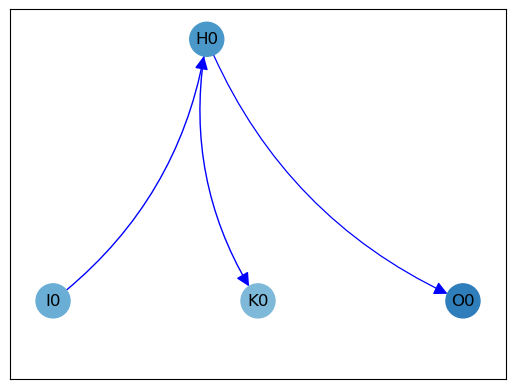

In [76]:
plotter.visualize_network(layers, weights, layout='shell',
                          show_edge_labels=False,#shell_order=[1,[2,3],[0,4]],
                          exclude_nodes={0: ['I1'], 3: ['O1']},savefig=True)

### 5. Specify the physics of the nodes
Before running any simulations, we need to specify the input currents and the physics of the hidden layer nodes. Parameters can either be specified directly or coupled from the `physics` module. 

In [77]:
# Specify two types of devices for the hidden layer
# 1. Propagator (standard parameters)
propagator = physics.Device('device_parameters.txt')
propagator.print_parameter('Rstore')
# 2. Memory (modify the parameters)
memory = physics.Device('device_parameters.txt')
memory.set_parameter('Rstore',2e7)
memory.print_parameter('Rstore')

The parameter Rstore=2000000.0 Ohm
The parameter Rstore=20000000.0 Ohm


In [78]:
# Specify the internal dynamics by supplying the RC constants to the hidden layer (six parameters)
layers[1].assign_device(propagator)
layers[2].assign_device(memory)
# Tweak the threshold voltage
Vthres=1.0
layers[1].Vthres=Vthres
layers[2].Vthres=Vthres

# Calculate the unity_coeff to scale the weights accordingly
unity_coeff, Imax = propagator.inverse_gain_coefficient(propagator.eta_ABC, Vthres)
print(f'Unity coupling coefficient calculated as unity_coeff={unity_coeff:.4f}')
print(f'Imax is found to be {Imax} nA')

Unity coupling coefficient calculated as unity_coeff=0.0254
Imax is found to be 374.995312558593 nA


In [79]:
# Specify an exciting current square pulse and a constant inhibition
# Pulse train of 1 ns pulses
t_blue = [(6.0,8.0), (11.0,13.0), (16.0,18.0)] # at 6 ns, 11 ns, and 16 ns
I_blue = 2.05 # nA

# Constant inhibition to stabilize circuit
I_red = 0.0 # nA

# Use the square pulse function and specify which node in the input layer gets which pulse
layers[0].set_input_func(channel='blue',func_handle=physics.square_pulse, func_args=(t_blue, 1.0*Imax))
# Use the costant function to specify the inhibition from I0 to H0
layers[0].set_input_func(channel='red', func_handle=physics.constant, func_args=(I_red,))

### 6. Evolve in time

In [80]:
# Start time t, end time T
t = 0.0
T = 20.0 # ns
# To sample result over a fixed time-step, use savetime
savestep = 0.1
savetime = savestep
# These parameters are used to determine an appropriate time step each update
dtmax = 0.1 # ns 
dVmax = 0.005 # V

nw.reset(layers)
# Create a log over the dynamic data
time_log = logger.Logger(layers,channels) # might need some flags

start = time.time()

while t < T:
    # evolve by calculating derivatives, provides dt
    dt = tm.evolve(t, layers, dVmax, dtmax )

    # update with explicit Euler using dt
    # supplying the unity_coeff here to scale the weights
    tm.update(dt, t, layers, weights, unity_coeff)
    
    t += dt
    # Log the progress
    if t > savetime :
        # Put log update here to have (more or less) fixed sample rate
        # Now this is only to check progress
        print(f'Time at t={t} ns') 
        savetime += savestep
    
    time_log.add_tstep(t, layers, unity_coeff)

end = time.time()
print('Time used:',end-start)

# This is a large pandas data frame of all system variables
result = time_log.get_timelog()

Time at t=0.2 ns
Time at t=0.30000000000000004 ns
Time at t=0.4 ns
Time at t=0.5 ns
Time at t=0.6 ns
Time at t=0.7 ns
Time at t=0.7999999999999999 ns
Time at t=0.8999999999999999 ns
Time at t=0.9999999999999999 ns
Time at t=1.0999999999999999 ns
Time at t=1.2 ns
Time at t=1.3 ns
Time at t=1.4000000000000001 ns
Time at t=1.5000000000000002 ns
Time at t=1.6000000000000003 ns
Time at t=1.7000000000000004 ns
Time at t=1.8000000000000005 ns
Time at t=1.9000000000000006 ns
Time at t=2.0000000000000004 ns
Time at t=2.1000000000000005 ns
Time at t=2.2000000000000006 ns
Time at t=2.3000000000000007 ns
Time at t=2.400000000000001 ns
Time at t=2.500000000000001 ns
Time at t=2.600000000000001 ns
Time at t=2.700000000000001 ns
Time at t=2.800000000000001 ns
Time at t=2.9000000000000012 ns
Time at t=3.0000000000000013 ns
Time at t=3.1000000000000014 ns
Time at t=3.2000000000000015 ns
Time at t=3.3000000000000016 ns
Time at t=3.4000000000000017 ns
Time at t=3.5000000000000018 ns
Time at t=3.600000000

### 7. Visualize results
Plot results specific to certain nodes

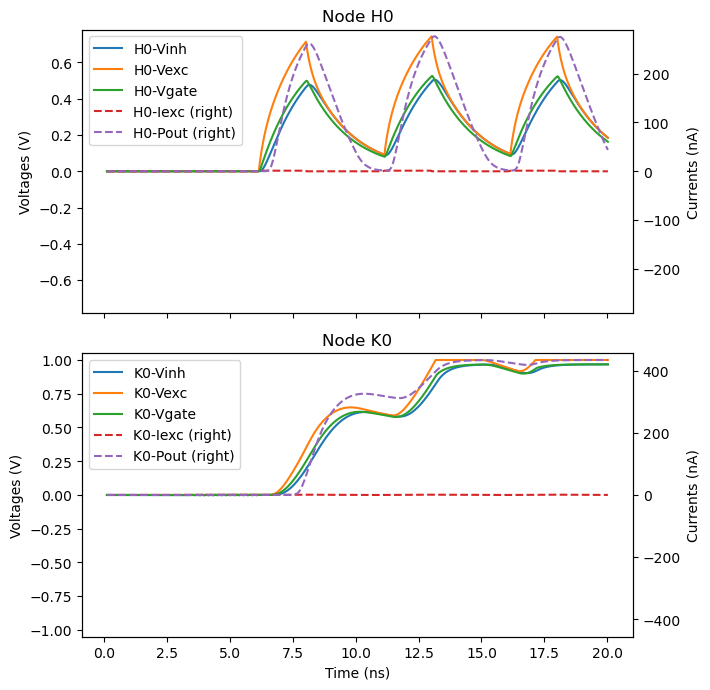

In [81]:
#nodes = ['H0','H1','H2','H3','H4']

nodes = ['H0','K0']
plotter.plot_nodes(result, nodes, onecolumn=True)

For this system it's quite elegant to use the `plot_chainlist` function, taking as arguments a graph object, the source node (I1 for blue) and a target node (O1 for blue)

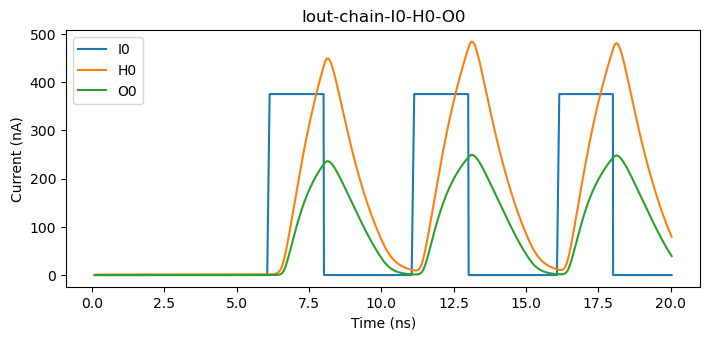

In [82]:
# Variable G contains a graph object descibing the network
G = plotter.retrieve_G(layers, weights)
plotter.plot_chainlist(result,G,'I0','O0')

Plot specific attributes

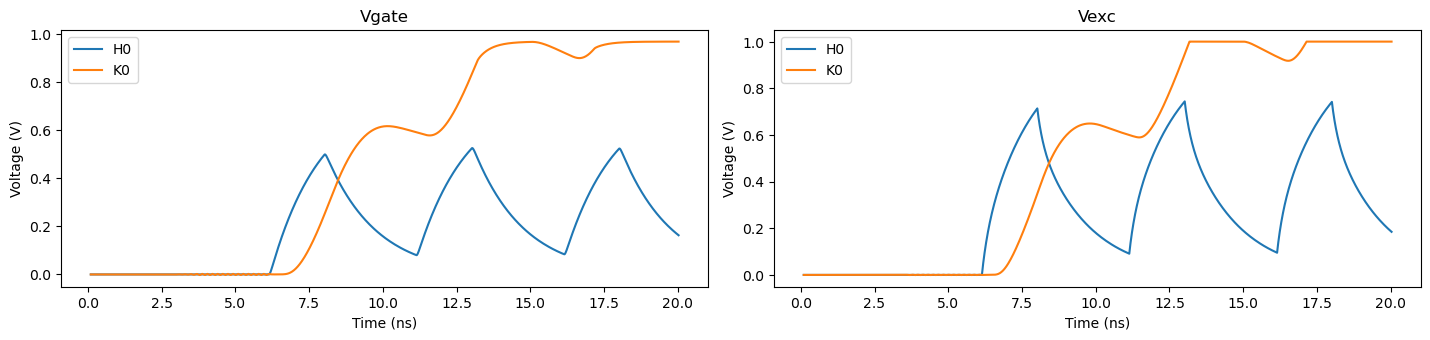

In [83]:
attr_list = ['Vgate','Vexc']
plotter.plot_attributes(result, attr_list)

We can be totally specific if we want. First we list the available columns to choose from

In [84]:
print(result.columns)

Index(['Time', 'I0-Iout-blue', 'I1-Iout-red', 'H0-Vinh', 'H0-Vexc', 'H0-Vgate',
       'H0-Iinh', 'H0-Iexc', 'H0-Iout', 'H0-ISD', 'H0-Pout', 'K0-Vinh',
       'K0-Vexc', 'K0-Vgate', 'K0-Iinh', 'K0-Iexc', 'K0-Iout', 'K0-ISD',
       'K0-Pout', 'O0-Iout-blue', 'O1-Iout-red'],
      dtype='object')


In [85]:
plotter.visualize_dynamic_result(result, ['I0-Iout-red','I1-Iout-blue'])

KeyError: "None of [Index(['I0-Iout-red', 'I1-Iout-blue'], dtype='object')] are in the [columns]"

In [ ]:
plotter.visualize_dynamic_result(result, ['H0-ISD','K0-ISD'])

In [ ]:
plotter.visualize_transistor(propagator.transistorIV_example())

In [ ]:
plotter.visualize_LED_efficiency(propagator.eta_example(propagator.eta_ABC))